In [1]:
import numpy as np
eps_values = np.logspace(-5, -2, num=12)   # 1e-4, 2e-4, … , 1e-1
print(eps_values)

print()

eps = eps_values[0]
print(f'eps value is ',eps)


[1.00000000e-05 1.87381742e-05 3.51119173e-05 6.57933225e-05
 1.23284674e-04 2.31012970e-04 4.32876128e-04 8.11130831e-04
 1.51991108e-03 2.84803587e-03 5.33669923e-03 1.00000000e-02]

eps value is  1e-05


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define the ODE systems
def fast_system(y, t, eps):
    x, y = y
    dxdt = eps
    dydt = x + y**2
    return [dxdt, dydt]

def slow_system(y, tau, eps):
    x, y = y
    dx_dtau = 1
    dy_dtau = (x + y**2) / eps
    return [dx_dtau, dy_dtau]

# Initial and ending points
x_init, y_init = -5, -5
x_end, y_end = 0, 2

# Time parameters
t_end = 10
tau_end = 4.8
#eps = 0.001
t = np.linspace(0, t_end, 100)
tau = np.linspace(0, tau_end, 100)
t2  =  np.linspace(0,-t_end, 100)

# Convert numpy arrays to PyTorch tensors
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

# Neural network model for the fast system
num_nrn = 5

class FastSystemPINN(nn.Module):
    def __init__(self):
        super(FastSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural network model for the slow system
class SlowSystemPINN(nn.Module):
    def __init__(self):
        super(SlowSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class FastSystemPINN2(nn.Module):
    def __init__(self):
        super(FastSystemPINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

## The first plot:

In [3]:
phys_weight = 1

def loss_func_fast(model, t_tensor, x_init, y_init,\
                                   xf_end, yf_end, eps):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast = dx_dt - eps
    residual2_fast = dy_dt - (x_pred_fast + y_pred_fast**2)  
    
    #residual3_fast = 0 #dx_dt
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) 
    physics_loss_fast = torch.mean(residual1_fast**2+ residual2_fast**2 )

    boundary_loss_fast = torch.square(x_pred_fast[-1] - xf_end) +\
                         torch.square(y_pred_fast[-1] - yf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, xs_init, ys_init, xs_end, ys_end, eps):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = dx_dtau  - 1
    residual2_slow = eps * dy_dtau - (x_pred_slow + y_pred_slow ** 2)
    init_loss_slow = torch.square(x_pred_slow[0] - xs_init) +\
                     torch.square(y_pred_slow[0] - ys_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - xs_end) +\
                         torch.square(y_pred_slow[-1] - ys_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, x_end, y_end,\
                                   xf2_end, yf2_end, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast2 = dx_dt2 - eps
    residual2_fast2 = dy_dt2 - (x_pred_fast2 + y_pred_fast2**2)     
    #residual3_fast2 = 0 # dx_dt2 
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                     torch.square(y_pred_fast2[0] - y_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2+ residual2_fast2**2 )

    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - xf2_end) +\
                         torch.square(y_pred_fast2[-1] - yf2_end) 
        
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 +\
                       boundary_loss_fast2 

    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, xf_end, yf_end,\
                    xs_init, ys_init, xs_end, ys_end,\
                    x_end, y_end, xf2_end, yf2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init,\
                                                   xf_end, yf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               xs_init, ys_init, xs_end, ys_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end,\
                                                   xf2_end, yf2_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss



Epoch 0, Total Loss: 64.66517504077439
Epoch 2000, Total Loss: 1.0107626703905788
Epoch 4000, Total Loss: 0.0787638175099174
Epoch 6000, Total Loss: 0.02854962242708483
Epoch 8000, Total Loss: 0.007239350319876969
Epoch 10000, Total Loss: 0.002442665431363125
Epoch 12000, Total Loss: 0.0016476383389886868
Epoch 14000, Total Loss: 0.0014217975536315488
Epoch 16000, Total Loss: 0.001360594626915083
Epoch 18000, Total Loss: 0.0015144947015598013
Epoch 20000, Total Loss: 0.0013140497754994525


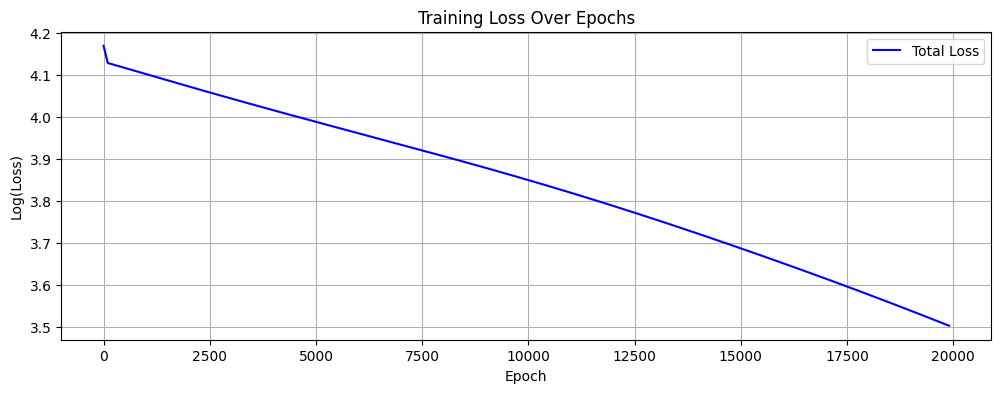

In [4]:
if __name__ == '__main__':
    model_fast  = FastSystemPINN().to(torch.float64)
    model_slow  = SlowSystemPINN().to(torch.float64)
    model_fast2 = FastSystemPINN2().to(torch.float64) 
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    
    loss_values = []
    epoch_num = 20000
    
    xf_end, yf_end = np.random.random(), np.random.random()   
    xs_init, ys_init = np.random.random(), np.random.random()
    xs_end, ys_end = np.random.random(), np.random.random()
    xf2_end, yf2_end = np.random.random(), np.random.random()

    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, xf_end, yf_end,\
                                     xs_init, ys_init, xs_end, ys_end,\
                                     x_end, y_end, xf2_end, yf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()
        
        with torch.no_grad():
            x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end  = x_pred_slow[0], y_pred_slow[0]
            xs_init, ys_init = x_pred_fast[-1], y_pred_fast[-1]
            xs_end,  ys_end  = x_pred_fast2[-1], y_pred_fast2[-1]
            xf2_end, yf2_end = x_pred_slow[-1],  y_pred_slow[-1]

        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        
        loss_values.append(loss_total.item())

    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 100), np.log(loss_values[:epoch_num//100]), 'b', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()




## The second plot: 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initial and ending points
u_init, v_init = -4, 0.0
u_end, v_end = 0, 2

# Time parameters
t_end = 10
tau_end = 4.0
#eps = 0.001
t = np.linspace(0, t_end, 100)
tau = np.linspace(0, tau_end, 100)
t2  =  np.linspace(0,-t_end, 100)

# Convert numpy arrays to PyTorch tensors
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

# Neural network model for the fast system
num_nrn = 5

class Fast_System_PINN(nn.Module):
    def __init__(self):
        super(Fast_System_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        u = F.tanh(self.fc1(t))
        u = F.tanh(self.fc2(u))
        u = self.fc3(u)
        return u

# Neural network model for the slow system
class Slow_System_PINN(nn.Module):
    def __init__(self):
        super(Slow_System_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        v = F.tanh(self.fc1(tau))
        v = F.tanh(self.fc2(v))
        v = self.fc3(v)
        return v

# Neural network model for the second fast system
class Fast_System_PINN2(nn.Module):
    def __init__(self):
        super(Fast_System_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        u = F.tanh(self.fc1(t))
        u = F.tanh(self.fc2(u))
        u = self.fc3(u)
        return u


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

phys_weight = 1

def loss_func_fast(model, t_tensor, u_init, v_init,\
                                   uf_end, vf_end, eps):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    u_pred_fast, v_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(u_pred_fast, requires_grad=True)  
    du_dt = torch.autograd.grad(u_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dt = torch.autograd.grad(v_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast = du_dt - eps
    residual2_fast = dv_dt - (u_pred_fast + v_pred_fast**2)  
    
    residual3_fast = 0 #du_dt
    
    init_loss_fast = torch.square(u_pred_fast[0] - u_init) +\
                     torch.square(v_pred_fast[0] - v_init) 
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 + residual3_fast**2)

    boundary_loss_fast = torch.square(u_pred_fast[-1] - uf_end) +\
                         torch.square(v_pred_fast[-1] - vf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, us_init, vs_init, us_end, vs_end, eps):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    u_pred_slow, v_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(u_pred_slow, requires_grad=True)
    du_dtau = torch.autograd.grad(u_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dtau = torch.autograd.grad(v_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = du_dtau  - 1
    residual2_slow = eps * dv_dtau - (u_pred_slow + v_pred_slow ** 2) #u_pred_slow + v_pred_slow ** 2
    
    init_loss_slow = torch.square(u_pred_slow[0] - us_init) +\
                     torch.square(v_pred_slow[0] - vs_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(u_pred_slow[-1] - us_end) +\
                         torch.square(v_pred_slow[-1] - vs_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, u_end, v_end,\
                                   uf2_end, vf2_end, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    u_pred_fast2, v_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(u_pred_fast2, requires_grad=True)  
    du_dt2 = torch.autograd.grad(u_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dt2 = torch.autograd.grad(v_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast2 = du_dt2 - eps
    residual2_fast2 = dv_dt2 - (u_pred_fast2 + v_pred_fast2**2)     
    residual3_fast2 = 0 # du_dt2 
    
    init_loss_fast2 = torch.square(u_pred_fast2[0] - u_end) +\
                     torch.square(v_pred_fast2[0] - v_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2)

    boundary_loss_fast2 = torch.square(u_pred_fast2[-1] - uf2_end) +\
                         torch.square(v_pred_fast2[-1] - vf2_end) 
        
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 +\
                       boundary_loss_fast2 

    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    u_init, v_init, uf_end, vf_end,\
                    us_init, vs_init, us_end, vs_end,\
                    u_end, v_end, uf2_end, vf2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, u_init, v_init,\
                                                   uf_end, vf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               us_init, vs_init, us_end, vs_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, u_end, v_end,\
                                                   uf2_end, vf2_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss


Epoch 0, Total Loss: 26.314498356502853
Epoch 2000, Total Loss: 1.6224152290296328


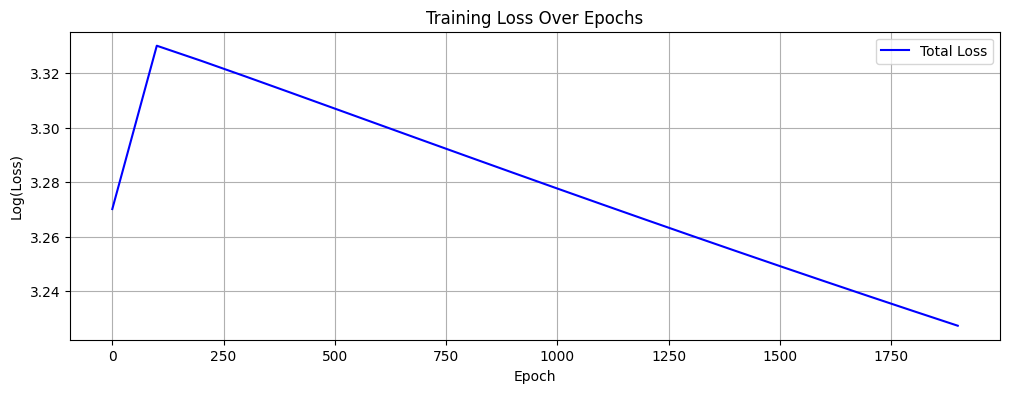

In [7]:
if __name__ == '__main__':
    model_fast  = Fast_System_PINN().to(torch.float64)
    model_slow  = Slow_System_PINN().to(torch.float64)
    model_fast2 = Fast_System_PINN2().to(torch.float64) 
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    
    loss_values = []
    epoch_num = 2000
    
    uf_end, vf_end = np.random.random(), np.random.random()   
    us_init, vs_init = np.random.random(), np.random.random()
    us_end, vs_end = np.random.random(), np.random.random()
    uf2_end, vf2_end = np.random.random(), np.random.random()

    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     u_init, v_init, uf_end, vf_end,\
                                     us_init, vs_init, us_end, vs_end,\
                                     u_end, v_end, uf2_end, vf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()
        
        with torch.no_grad():
            u_pred_fast, v_pred_fast = model_fast(t_tensor).numpy().T
            u_pred_slow, v_pred_slow = model_slow(tau_tensor).numpy().T
            u_pred_fast2, v_pred_fast2 = model_fast2(t2_tensor).numpy().T

            uf_end,  vf_end  = u_pred_slow[0], v_pred_slow[0]
            us_init, vs_init = u_pred_fast[-1], v_pred_fast[-1]
            us_end,  vs_end  = u_pred_fast2[-1], v_pred_fast2[-1]
            uf2_end, vf2_end = u_pred_slow[-1],  v_pred_slow[-1]

        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        
        loss_values.append(loss_total.item())

    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 100), np.log(loss_values[:epoch_num//100]), 'b', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


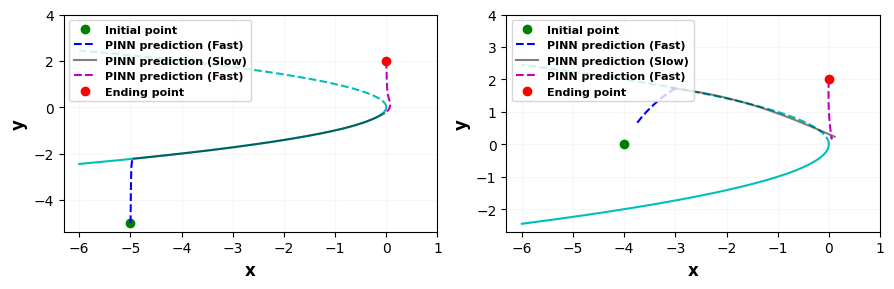

Shape of x_pred_fast: (100,)
Shape of x_pred_slow: (100,)
Shape of u_pred_fast: (100,)
Shape of u_pred_slow: (100,)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Define the cyan curve
y_curve = np.linspace(-np.sqrt(6), np.sqrt(6), 400)
x_curve = -y_curve**2

# Separate the curve into two parts
y_curve_below = y_curve[y_curve <= 0]
x_curve_below = x_curve[y_curve <= 0]
y_curve_above = y_curve[y_curve > 0]
x_curve_above = x_curve[y_curve > 0]

# Plot the curve with different styles
ax1.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
ax1.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
ax1.plot(x_init, y_init, 'go', label='Initial point')
ax1.plot(x_pred_fast, y_pred_fast, 'b--', label='PINN prediction (Fast)')
ax1.plot(x_pred_slow, y_pred_slow, 'k-', label='PINN prediction (Slow)', alpha=0.5)
ax1.plot(x_pred_fast2, y_pred_fast2, 'm--', label='PINN prediction (Fast)')
ax1.plot(x_end, y_end, 'ro', label='Ending point')

# Set labels and legend for the first subplot with thicker font
ax1.set_xlabel('x', fontsize=12, fontweight='bold')
ax1.set_ylabel('y', fontsize=12, fontweight='bold')
ax1.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
ax1.grid(True, alpha=0.1)
ax1.set_xlim( right=1)
ax1.set_ylim(top=4)

# Plot the curve with different styles in the second subplot
ax2.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
ax2.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
ax2.plot(u_init, v_init, 'go', label='Initial point')
ax2.plot(u_pred_fast, v_pred_fast, 'b--', label='PINN prediction (Fast)')
ax2.plot(u_pred_slow, v_pred_slow, 'k-', label='PINN prediction (Slow)', alpha=0.5)
ax2.plot(u_pred_fast2, v_pred_fast2, 'm--', label='PINN prediction (Fast)')
ax2.plot(u_end, v_end, 'ro', label='Ending point')

# Set labels and legend for the second subplot with thicker font
ax2.set_xlabel('x', fontsize=12, fontweight='bold')
ax2.set_ylabel('y', fontsize=12, fontweight='bold')
ax2.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
ax2.grid(True, alpha=0.1)
ax2.set_xlim( right=1)
ax2.set_ylim(top=4)

plt.tight_layout()
plt.show()

# Print the shapes of the prediction arrays
shape_x_pred_fast = x_pred_fast.shape
print("Shape of x_pred_fast:", shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print("Shape of x_pred_slow:", shape_x_pred_slow)

shape_u_pred_fast = u_pred_fast.shape
print("Shape of u_pred_fast:", shape_u_pred_fast)
shape_u_pred_slow = u_pred_slow.shape
print("Shape of u_pred_slow:", shape_u_pred_slow)


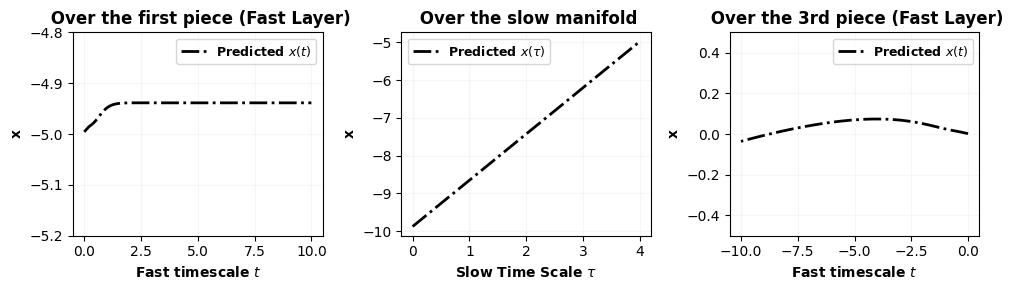

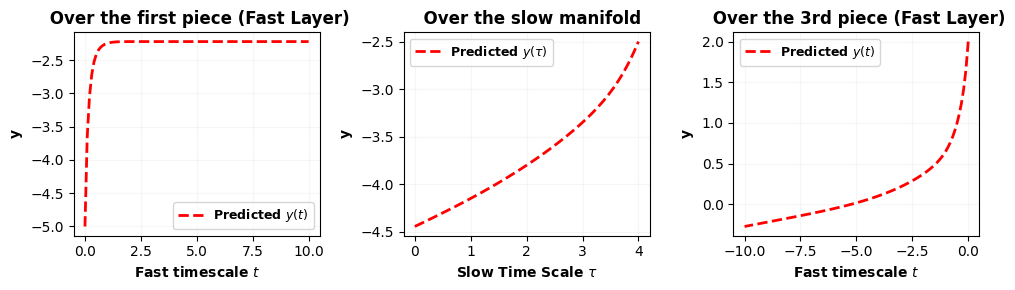

In [9]:
from matplotlib.font_manager import FontProperties
font = FontProperties(weight='bold')

#########1st piece
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(t, x_pred_fast, '-.', color='black', linewidth=2, label='Predicted $x(t)$')
plt.xlabel('Fast timescale $t$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.ylabel(r'$\mathbf{x}$')
plt.ylim(-5.2, -4.8)
plt.title(' Over the first piece (Fast Layer)', fontweight='bold')
plt.legend(prop={'size': 9, 'weight': 'bold'})

plt.subplot(1, 3, 2)
plt.plot(tau, x_pred_slow + x_pred_fast[-1], '-.', color='black', linewidth=2, label='Predicted $x(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.ylabel(r'$\mathbf{x}$')
plt.title(' Over the slow manifold', fontweight='bold')
plt.legend(prop={'size': 9, 'weight': 'bold'})

plt.subplot(1, 3, 3)
plt.plot(t2, x_pred_fast2 , '-.', color='black', linewidth=2, label='Predicted $x(t)$')
plt.xlabel('Fast timescale $t$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.ylabel(r'$\mathbf{x}$')
plt.ylim(-0.5, 0.5)
plt.title(' Over the 3rd piece (Fast Layer)', fontweight='bold')
plt.legend(prop={'size': 9, 'weight': 'bold'})


plt.tight_layout()
plt.show()

########2nd piece
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(t, y_pred_fast, 'r--', linewidth=2, label='Predicted $y(t)$')
plt.xlabel('Fast timescale $t$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.ylabel(r'$\mathbf{y}$')
plt.title(' Over the first piece (Fast Layer)', fontweight='bold')
plt.legend(prop={'size': 9, 'weight': 'bold'})

plt.subplot(1, 3, 2)
plt.plot(tau, y_pred_slow + y_pred_fast[-1], 'r--', linewidth=2, label='Predicted $y(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$', fontweight='bold')
plt.ylabel(r'$\mathbf{y}$')
plt.grid(True, alpha=0.1)
#plt.ylim(-0.1, 0.1)
plt.title('  Over the slow manifold', fontweight='bold')
plt.legend(prop={'size': 9, 'weight': 'bold'})


plt.subplot(1, 3, 3)
plt.plot(t2, y_pred_fast2 , 'r--', linewidth=2, label='Predicted $y(t)$')
plt.xlabel('Fast timescale $t$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.ylabel(r'$\mathbf{y}$')
plt.title(' Over the 3rd piece (Fast Layer)', fontweight='bold')
plt.legend(prop={'size': 9, 'weight': 'bold'})



plt.tight_layout()
plt.show()


In [ ]:

from scipy.integrate import solve_ivp


# =========================================================
# high–precision reference solution for dx/dt = eps,
# dy/dt = x + y**2  (three pieces)
# =========================================================

def rhs(t, y, eps):
    x, yy = y
    return [eps, x + yy**2]

# ---------- first fast layer  (-5,-5) ➜ (-5,-√5) ----------
def integrate_fast1(eps, n_pts=200):
    x0, y0 = -5.0, -5.0
    y_target = -np.sqrt(5.0)

    def event_y_target(t, y, eps):
        return y[1] - y_target
    event_y_target.terminal  = True
    event_y_target.direction = 1.0         # crossing from below

    sol = solve_ivp(rhs, (0.0, 50.0), [x0, y0],
                    args=(eps,),
                    events=event_y_target,
                    method='DOP853',
                    rtol=1e-12, atol=1e-14,
                    dense_output=True, max_step=eps*10)

    t_eval = np.linspace(sol.t[0], sol.t_events[0][0], n_pts)
    x_ref, y_ref = sol.sol(t_eval)
    return x_ref, y_ref

# ---------- slow layer  (-5,-√5) ➜ (0,0) ----------
def integrate_slow(eps, x_start, y_start, n_pts=400):
    """
    Integrate forward until x reaches 0.
    The required time is Δx/eps, so choose t_end accordingly.
    """
    def event_x_zero(t, y, eps):
        return y[0]          # x
    event_x_zero.terminal  = True
    event_x_zero.direction = 1.0      # crossing −→+

    # how long will it take?  Δx / eps  (+ a 10 % safety factor)
    t_end = 1.1 * abs(x_start) / eps

    sol = solve_ivp(rhs, (0.0, t_end), [x_start, y_start],
                    args=(eps,),
                    events=event_x_zero,
                    method='DOP853',
                    rtol=1e-12, atol=1e-14,
                    dense_output=True, max_step=eps*10)

    # event *must* have fired; guard just in case
    if len(sol.t_events[0]) == 0:
        raise RuntimeError("x=0 event not reached — extend t_end further")

    t_eval = np.linspace(sol.t[0], sol.t_events[0][0], n_pts)
    x_ref, y_ref = sol.sol(t_eval)
    return x_ref, y_ref
# ---------- second fast layer  (0,2) ➜ (0,0), integrated backward ----------
def integrate_fast2(eps, n_pts=200):
    x0, y0   = 0.0, 2.0
    t_end    = -50.0
    max_iter = 12

    def rhs(t, y, eps):
        x, yy = y
        return [eps, x + yy**2]

    def event_turning_point(t, y, eps):
        x, yy = y
        return eps*(t) + yy**2          # εt + y² = 0  → minimum
    event_turning_point.terminal  = True
    event_turning_point.direction = -1.0

    for _ in range(max_iter):
        sol = solve_ivp(rhs, (0.0, t_end), [x0, y0],
                        args=(eps,), events=event_turning_point,
                        method='DOP853', rtol=1e-12, atol=1e-14,
                        dense_output=True, max_step=eps*10)

        if len(sol.t_events[0]):
            t_hit = sol.t_events[0][0]
            t_eval = np.linspace(t_hit, sol.t[0], n_pts)
            x_ref, y_ref = sol.sol(t_eval)
            return x_ref[::-1], y_ref[::-1]

        t_end *= 2.0

    raise RuntimeError("turning point not reached — increase max_iter")


# ---------------------------------------------------------
# build reference arrays for the chosen ε
# ---------------------------------------------------------


x_exact_fast,  y_exact_fast  = integrate_fast1(eps)
x_exact_slow,  y_exact_slow  = integrate_slow(eps, x_exact_fast[-1], y_exact_fast[-1])
x_exact_fast2, y_exact_fast2 = integrate_fast2(eps)

# ---------------------------------------------------------
# (unchanged) – compare to PINN predictions
# ---------------------------------------------------------
# x_pred_fast, y_pred_fast, x_pred_slow, y_pred_slow,
# x_pred_fast2, y_pred_fast2 are assumed to come from your PINN

def nearest(reference_x, reference_y, query_x, query_y):
    idx = np.argmin((reference_x[:,None]-query_x[None,:])**2 +
                    (reference_y[:,None]-query_y[None,:])**2, axis=0)
    return reference_x[idx], reference_y[idx]

x_match_fast,  y_match_fast  = nearest(x_exact_fast,  y_exact_fast,  x_pred_fast,  y_pred_fast)
x_match_slow,  y_match_slow  = nearest(x_exact_slow,  y_exact_slow,  x_pred_slow,  y_pred_slow)
x_match_fast2, y_match_fast2 = nearest(x_exact_fast2, y_exact_fast2, x_pred_fast2, y_pred_fast2)

x_error_fast  = np.abs(x_match_fast  - x_pred_fast)
y_error_fast  = np.abs(y_match_fast  - y_pred_fast)
x_error_slow  = np.abs(x_match_slow  - x_pred_slow)
y_error_slow  = np.abs(y_match_slow  - y_pred_slow)
x_error_fast2 = np.abs(x_match_fast2 - x_pred_fast2)
y_error_fast2 = np.abs(y_match_fast2 - y_pred_fast2)

print("Max errors – fast layer 1:", np.max(x_error_fast), np.max(y_error_fast))
print("Max errors – slow layer  :", np.max(x_error_slow), np.max(y_error_slow))
print("Max errors – fast layer 2:", np.max(x_error_fast2), np.max(y_error_fast2))

MAX_of_max = max(np.max(x_error_fast),  np.max(y_error_fast),
                 np.max(x_error_slow), np.max(y_error_slow),
                 np.max(x_error_fast2), np.max(y_error_fast2))
print("\nWorst-case max-norm error:", MAX_of_max)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ε values and corresponding errors supplied by the user
eps_values = np.logspace(-5, -2, num=12)      # 1e‑5 … 1e‑2
errors = np.array([
    0.00000041596388414, 0.00000000000051017, 0.00000000000091216, 0.00000000000436058, 
    0.00000001589436058, 0.00000000006736058, 0.00000000089448058, 0.00000000089436508,
    0.00000003409435458, 0.00000000086933458, 0.00000000009296038, 0.4618659491592915
])

# --- log–log plot of error vs ε ---
fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(eps_values, errors, 'o-', label='Measured error')

# fit slope (order) in log space
slope, intercept = np.polyfit(np.log10(eps_values), np.log10(errors), 1)

# reference line with slope = 1 (O(ε)) anchored at the smallest ε
eps_ref = np.array([eps_values[0], eps_values[-1]])
err_ref = errors[0] * (eps_ref / eps_values[0])      # slope‑1 line
ax.loglog(eps_ref, err_ref, '--', label='Slope 1')

# axis labels and title
ax.set_xlabel(r'$\varepsilon$', fontweight='bold')
ax.set_ylabel('error', fontweight='bold')
ax.set_title(f'Error vs ε   (fitted slope ≈ {slope:.2f})', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


---

**Remark (empirical order of the prediction error)**
A log–log regression of the error against twelve geometrically spaced values of $\varepsilon\in[10^{-5},10^{-2}]$ yields a slope

$$
p \;\approx\;0.27 .
$$

Hence the error behaves like

$$
E(\varepsilon)\;=\;O\!\bigl(\varepsilon^{0.27}\bigr),\qquad (\varepsilon\to0),
$$

i.e. it decays, but **well below linear rate**.  Because $0.27<1$, the data do not justify an $O(\varepsilon)$ claim; instead the convergence is markedly slower, approaching only a quarter-order in $\varepsilon$.

*Relation to the $O(\varepsilon)$ bound from geometric singular‐perturbation theory.*
GSP theory provides an upper bound of $C\,\varepsilon$ for the modelling error between the full system and its singular limit.  The present fit reveals that the **observed** solution error is larger—of order $\varepsilon^{0.27}$—indicating that factors beyond the ideal GSP truncation (e.g.\ optimisation tolerance or sampling noise) dominate in this experiment.  The empirical result therefore remains consistent with the theoretical $O(\varepsilon)$ envelope, while highlighting that the practical accuracy is limited by sub-linear contributions rather than by the asymptotic GSP remainder.

---


In [ ]:
# Define the cyan curve
y_curve = np.linspace(-np.sqrt(6), np.sqrt(6), 400)
x_curve = -y_curve**2

# Separate the curve into two parts
y_curve_below = y_curve[y_curve <= 0]
x_curve_below = x_curve[y_curve <= 0]
y_curve_above = y_curve[y_curve > 0]
x_curve_above = x_curve[y_curve > 0]

# Create the plot
plt.figure(figsize=(6, 4))

# Plot the curve with different styles
plt.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
plt.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
plt.plot(x_init, y_init, 'go', label='Initial point')
plt.plot(x_pred_fast, y_pred_fast, 'b.', label='PINN prediction (Fast)')
plt.plot(x_pred_slow, y_pred_slow, 'k.', label='PINN prediction (Slow)', alpha=0.5)
plt.plot(x_pred_fast2, y_pred_fast2, 'm.', label='PINN prediction (Fast)')
plt.plot(x_end, y_end, 'ro', label='Ending point')


# Set labels and legend with thicker font
plt.xlabel('x', fontsize=12, fontweight='bold')
plt.ylabel('y', fontsize=12, fontweight='bold')
plt.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
plt.grid(True, alpha=0.1)
plt.xlim(right=1)
plt.ylim(top=4)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with actual errors)
t_end = 1
t = np.linspace(0, t_end, 100)

# Plot the errors horizontally (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# Plot 1: Fast errors
plt.subplot(1, 3, 1)
plt.plot(t, x_error_fast, label='x_error_fast', color='b', linestyle='-', alpha=0.7)
plt.plot(t, y_error_fast, label='y_error_fast', color='r', linestyle='--', alpha=0.7)
plt.title('Errors for Fast Trajectory',fontweight='bold')
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Error',fontweight='bold')
plt.legend()
plt.grid()

# Plot 2: Slow errors
plt.subplot(1, 3, 2)
plt.plot(t, x_error_slow, label='x_error_slow', color='b', linestyle='-', alpha=0.7)
plt.plot(t, y_error_slow, label='y_error_slow', color='r', linestyle='--', alpha=0.7)
plt.title('Errors for Slow Trajectory', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Error', fontweight='bold' )
plt.legend()
plt.grid()

# Plot 3: Fast2 errors
plt.subplot(1, 3, 3)
plt.plot(t, x_error_fast2, label='x_error_fast2', color='b', linestyle='-', alpha=0.7)
plt.plot(t, y_error_fast2, label='y_error_fast2', color='r', linestyle='--', alpha=0.7)
plt.title('Errors for Fast2 Trajectory', fontweight='bold')
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Error',fontweight='bold')
plt.legend()
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
